## 链式法则验证

In [12]:
import tensorflow as tf 

# 构建待优化变量
x = tf.constant(1.)
w1 = tf.constant(2.)
b1 = tf.constant(1.)
w2 = tf.constant(2.)
b2 = tf.constant(1.)


with tf.GradientTape(persistent=True) as tape:
    # 非tf.Variable类型的张量需要人为设置记录梯度信息
    tape.watch([w1, b1, w2, b2])
    # 构建2层网络
    y1 = x * w1 + b1
    y2 = y1 * w2 + b2

# 独立求解出各个导数
dy2_dy1 = tape.gradient(y2, [y1])[0]
dy1_dw1 = tape.gradient(y1, [w1])[0]
dy2_dw1 = tape.gradient(y2, [w1])[0]

# 验证链式法则
print(dy2_dy1 * dy1_dw1)
print(dy2_dw1)

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


## Himmelblau 函数优化实战

有四个全局最小解，且值都为0，这个函数常用来检验优化算法的表现如何：

In [1]:
import  numpy as np
from    mpl_toolkits.mplot3d import Axes3D
from    matplotlib import pyplot as plt
import  tensorflow as tf


In [2]:
def himmelblau(x):
    # himmelblau函数实现
    return (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2

![pic](https://img-blog.csdnimg.cn/20190730101805276.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaWNhbzE5OTA=,size_16,color_FFFFFF,t_70)

In [3]:
x = np.arange(-6, 6, 0.1)
y = np.arange(-6, 6, 0.1)
print('x,y range:', x.shape, y.shape)
# 生成x-y平面采样网格点，方便可视化
X, Y = np.meshgrid(x, y)
print('X,Y maps:', X.shape, Y.shape)
Z = himmelblau([X, Y]) # 计算网格点上的函数值

x,y range: (120,) (120,)
X,Y maps: (120, 120) (120, 120)


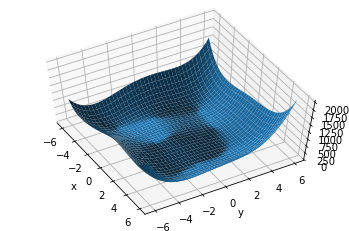

In [4]:
# 绘制himmelblau函数曲面
fig = plt.figure('himmelblau')
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z)
ax.view_init(60, -30)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [5]:
x = np.arange(-6, 6, 0.1)
y = np.arange(-6, 6, 0.1)
print('x,y range:', x.shape, y.shape)
# 生成x-y平面采样网格点，方便可视化
X, Y = np.meshgrid(x, y)
print('X,Y maps:', X.shape, Y.shape)
Z = himmelblau([X, Y]) # 计算网格点上的函数值


# 参数的初始化值对优化的影响不容忽视，可以通过尝试不同的初始化值，
# 检验函数优化的极小值情况
# [1., 0.], [-4, 0.], [4, 0.]
# x = tf.constant([4., 0.])
# x = tf.constant([1., 0.])
# x = tf.constant([-4., 0.])
x = tf.constant([-2., 2.])
# x = tf.constant([0., 0.])
for step in range(201):# 循环优化
    with tf.GradientTape() as tape: #梯度跟踪
        tape.watch([x]) # 记录梯度
        y = himmelblau(x) # 前向传播
    # 反向传播
    grads = tape.gradient(y, [x])[0] 
    # 更新参数,0.01为学习率
    x -= 0.01*grads
    # 打印优化的极小值
    if step % 20 == 0:
        print ('step {}: x = {}, f(x) = {}'
               .format(step, x.numpy(), y.numpy()))

x,y range: (120,) (120,)
X,Y maps: (120, 120) (120, 120)
step 0: x = [-2.3  2.5], f(x) = 49.999996185302734
step 20: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 40: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 60: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 80: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 100: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 120: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 140: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 160: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 180: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13
step 200: x = [-2.805118   3.1313126], f(x) = 2.273736618907049e-13


## 反向传播实战

In [44]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
N_SAMPLES=2000
TEST_SIZE=0.3
X,y=make_moons(n_samples=N_SAMPLES,noise=0.2,random_state=100)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=TEST_SIZE,random_state=42)
print(X.shape,y.shape)

(2000, 2) (2000,)


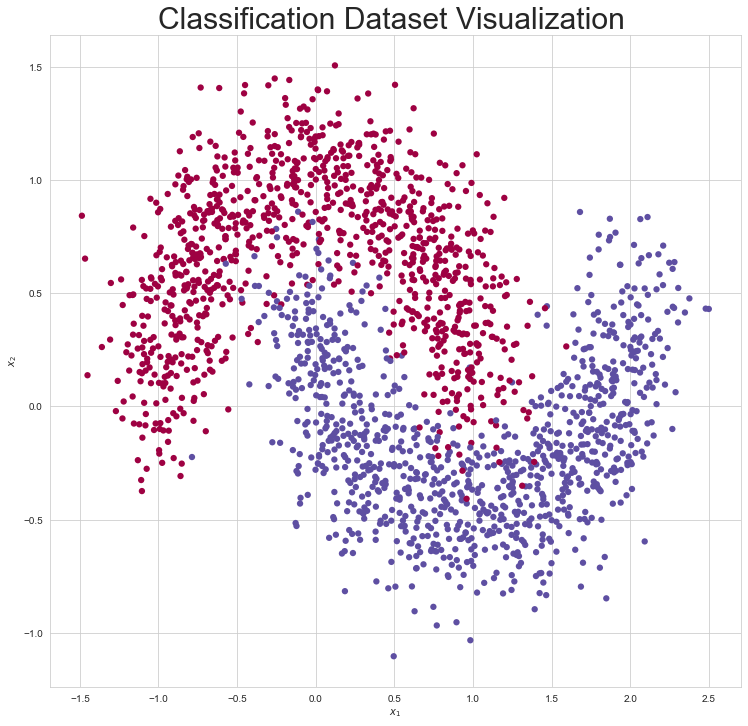

In [46]:
def make_plot(X,y,plot_name,file_name=None,XX=None,YY=None,preds=None,dark=False):
    if(dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes=plt.gca()
    axes.set(xlabel="$x_1$",ylabel="$x_2$")
    plt.title(plot_name,fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1,
        cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5],
        cmap="Greys", vmin=0, vmax=.6)
    # 绘制散点图，根据标签区分颜色
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral,
    edgecolors='none')
#     plt.savefig('dataset.svg')
    plt.show()
# 调用make_plot 函数绘制数据的分布，其中X 为2D 坐标，y 为标签
make_plot(X, y, "Classification Dataset Visualization ")

In [47]:
class Layer:
    # 全连接网络层
    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        #     :param int n_input: 输入节点数
        #     :param int n_neurons: 输出节点数
        #     :param str activation: 激活函数类型
        #     :param weights: 权值张量，默认类内部生成
        #     :param bias: 偏置，默认类内部生成
        # 通过正态分布初始化网络权值，初始化非常重要，不合适的初始化将导致网络不收敛
        self.weights = weights if weights is not None else np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias is not None else np.random.rand(n_neurons) * 0.1
        self.activation = activation  # 激活函数类型，如’sigmoid’
        self.last_activation = None  # 激活函数的输出值o
        self.error = None  # 用于计算当前层的delta 变量的中间变量
        self.delta = None  # 记录当前层的delta 变量，用于计算梯度

    # 实现网络层的前向传播如下：
    def activate(self, x):
        # 前向传播
        r = np.dot(x, self.weights) + self.bias  # X@W+b
        # 通过激活函数，得到全连接层的输出o
        self.last_activation = self._apply_activation(r)
        return self.last_activation

    # 其中self._apply_activation 实现了不同的激活函数的前向计算过程：
    def _apply_activation(self, r):
        # 计算激活函数的输出
        if self.activation is None:
            return r  # 无激活函数，直接返回
        # ReLU 激活函数
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        # tanh
        elif self.activation == 'tanh':
            return np.tanh(r)
        # sigmoid
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        return r

    # 针对于不同的激活函数，它们的导数计算实现如下：
    def apply_activation_derivative(self, r):
        # 计算激活函数的导数
        # 无激活函数，导数为1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU 函数的导数实现
        elif self.activation == 'relu':
            grad = np.array(r, copy=True)
            grad[r > 0] = 1.
            grad[r <= 0] = 0.
            return grad
        # tanh 函数的导数实现
        elif self.activation == 'tanh':
            return 1 - r ** 2
        # Sigmoid 函数的导数实现
        elif self.activation == 'sigmoid':
            return r * (1 - r)
        return r

In [50]:
class NeuralNetwork:
    # 神经网络大类
    def __init__(self):
        self._layers = []  # 网络层对象列表

    def add_layer(self, layer):
        # 追加网络层
        self._layers.append(layer)

    # 网络的前向传播只需要循环调用个网络层对象的前向计算函数即可：
    def feed_forward(self, X):
        # 前向传播
        for layer in self._layers:
            # 依次通过各个网络层
            X = layer.activate(X)
        return X

    def backpropagation(self, X, y, learning_rate):
        # 反向传播算法实现
        # 前向计算，得到输出值
        output = self.feed_forward(X)
        
        for i in reversed(range(len(self._layers))):  # 反向循环
            layer = self._layers[i]  # 得到当前层对象
            # 如果是输出层
            if layer == self._layers[-1]:  # 对于输出层
                layer.error = y - output  # 计算2 分类任务的均方差的导数
                # 关键步骤：计算最后一层的delta，参考输出层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:  # 如果是隐藏层
                next_layer = self._layers[i + 1]  # 得到下一层对象
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                # 关键步骤：计算隐藏层的delta，参考隐藏层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)
                
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i 为上一网络层的输出
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
            # 梯度下降算法，delta 是公式中的负数，故这里用加号
            layer.weights += layer.delta * o_i.T * learning_rate

    def predict(self,x):
        output = self.feed_forward(x)
        return np.argmax(output,axis=-1)

    def accuracy(self,pre,y):
        return (np.sum(pre==y)*1.0)/len(pre)

    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        # 网络训练函数
        # one-hot 编码
        y_onehot = np.zeros((y_train.shape[0], 2))
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        
        mses = []
        accs=[]
        for i in range(max_epochs):  # 训练1000 个epoch
            for j in range(len(X_train)):  # 一次训练一个样本
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)
            if i % 10 == 0:
                # 打印出MSE Loss
                mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))
                mses.append(mse)
                print('Epoch: #%s, MSE: %f' % (i, float(mse)))
                # 统计并打印准确率
                acc=(self.accuracy(self.predict(X_test), y_test.flatten()) * 100)
                accs.append(acc)
                print('Accuracy: %.2f%%' % acc)
        return mses,accs

In [53]:
nn = NeuralNetwork() # 实例化网络类
nn.add_layer(Layer(2, 25, 'sigmoid')) # 隐藏层1, 2=>25
nn.add_layer(Layer(25, 50, 'sigmoid')) # 隐藏层2, 25=>50
nn.add_layer(Layer(50, 25, 'sigmoid')) # 隐藏层3, 50=>25
nn.add_layer(Layer(25, 2, 'sigmoid')) # 输出层, 25=>2

sigmoid_mses,sigmoid_accs = nn.train(X_train,X_test,y_train,y_test,0.001,500)

Epoch: #0, MSE: 0.265932
Accuracy: 50.50%
Epoch: #10, MSE: 0.249645
Accuracy: 52.00%
Epoch: #20, MSE: 0.248686
Accuracy: 82.83%
Epoch: #30, MSE: 0.247644
Accuracy: 85.00%
Epoch: #40, MSE: 0.246442
Accuracy: 83.33%
Epoch: #50, MSE: 0.244977
Accuracy: 82.83%
Epoch: #60, MSE: 0.243104
Accuracy: 82.50%
Epoch: #70, MSE: 0.240607
Accuracy: 82.50%
Epoch: #80, MSE: 0.237148
Accuracy: 82.83%
Epoch: #90, MSE: 0.232194
Accuracy: 82.50%
Epoch: #100, MSE: 0.224919
Accuracy: 82.33%
Epoch: #110, MSE: 0.214154
Accuracy: 82.33%
Epoch: #120, MSE: 0.198745
Accuracy: 81.83%
Epoch: #130, MSE: 0.178983
Accuracy: 82.83%
Epoch: #140, MSE: 0.158369
Accuracy: 83.00%
Epoch: #150, MSE: 0.141558
Accuracy: 83.33%
Epoch: #160, MSE: 0.129915
Accuracy: 84.00%
Epoch: #170, MSE: 0.122035
Accuracy: 84.67%
Epoch: #180, MSE: 0.116364
Accuracy: 85.17%
Epoch: #190, MSE: 0.111999
Accuracy: 85.83%
Epoch: #200, MSE: 0.108504
Accuracy: 86.00%
Epoch: #210, MSE: 0.105677
Accuracy: 86.33%
Epoch: #220, MSE: 0.103409
Accuracy: 87.17%

In [91]:
plt.rcParams['figure.dpi'] = 300 #分辨率

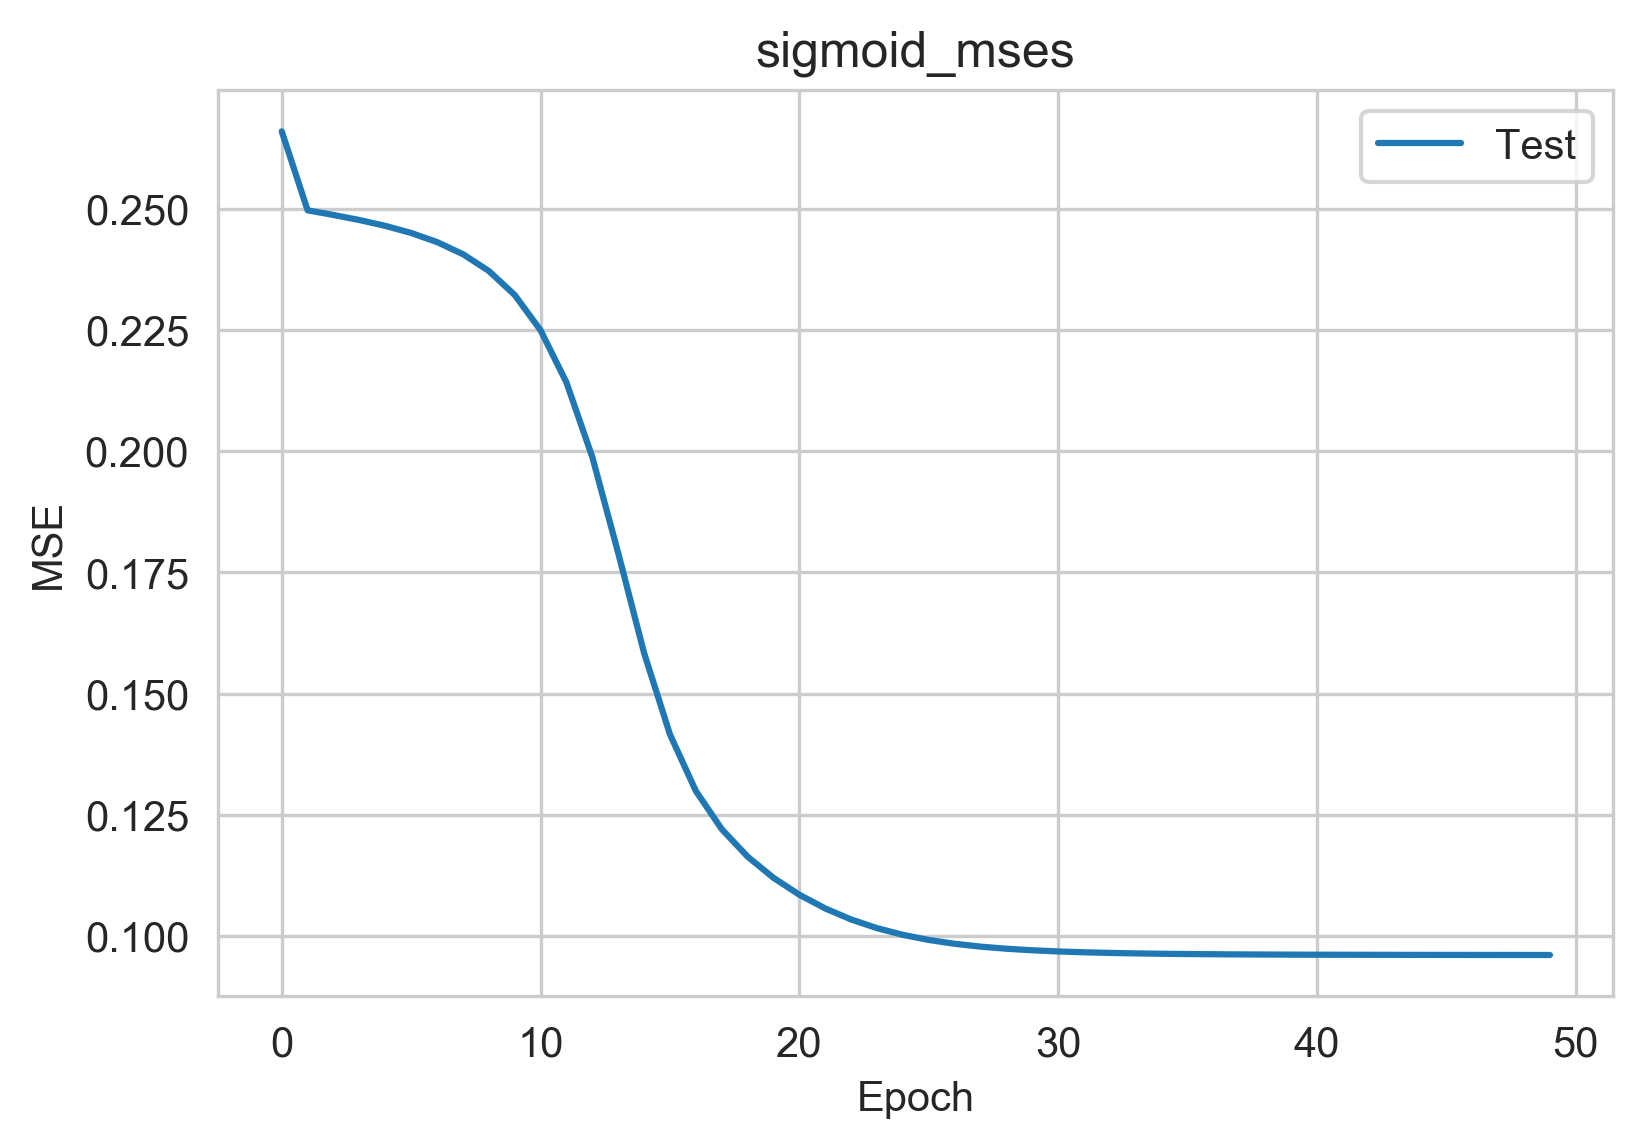

In [92]:
plt.figure()
plt.xlabel('Epoch')
plt.title("sigmoid_mses")
plt.ylabel('MSE')
plt.plot(sigmoid_mses,  label='Test')

plt.legend()

# plt.savefig('auto.svg')
plt.show() 

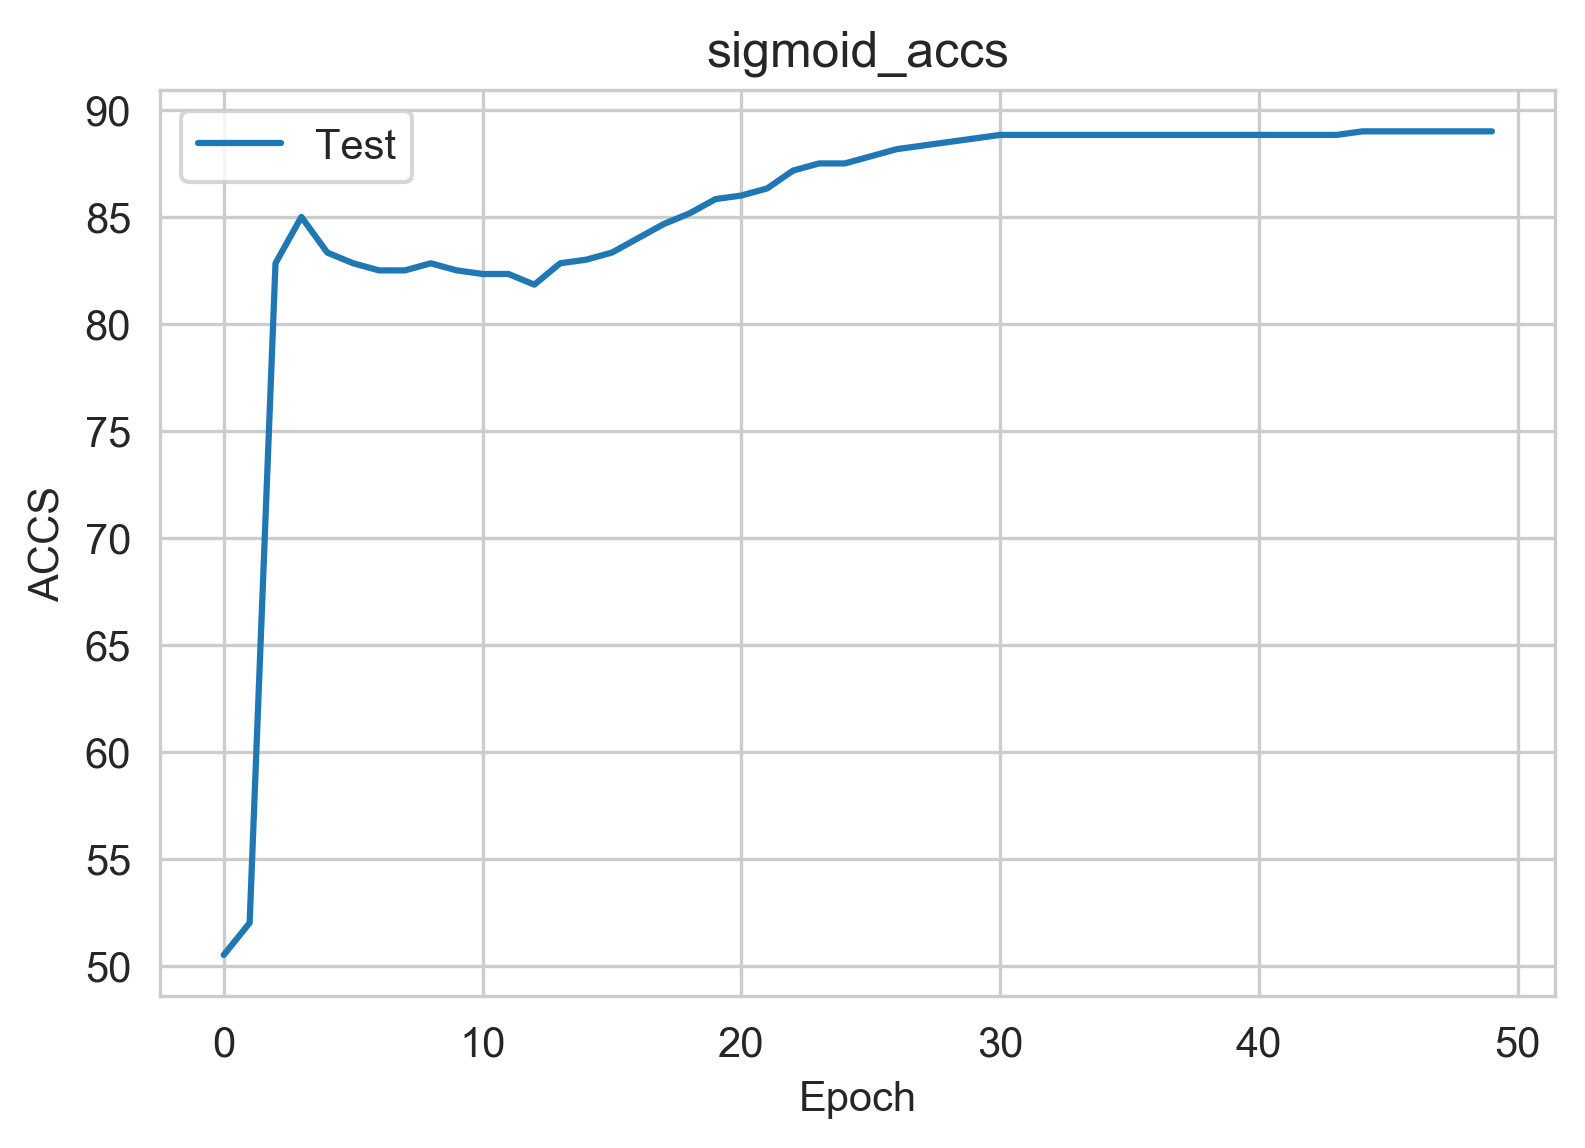

In [93]:
plt.figure()
plt.xlabel('Epoch')
plt.title("sigmoid_accs")
plt.ylabel('ACCS')
plt.plot(sigmoid_accs,  label='Test')

plt.legend()

# plt.savefig('auto.svg')
plt.show() 

In [63]:
nn = NeuralNetwork() # 实例化网络类
nn.add_layer(Layer(2, 25, 'relu')) # 隐藏层1, 2=>25
nn.add_layer(Layer(25, 50, 'relu')) # 隐藏层2, 25=>50
nn.add_layer(Layer(50, 25, 'relu')) # 隐藏层3, 50=>25
nn.add_layer(Layer(25, 2, 'sigmoid')) # 输出层, 25=>2

relu_mses,relu_accs = nn.train(X_train,X_test,y_train,y_test,0.001,500)

Epoch: #0, MSE: 0.179171
Accuracy: 87.67%
Epoch: #10, MSE: 0.093937
Accuracy: 89.17%
Epoch: #20, MSE: 0.086377
Accuracy: 89.50%
Epoch: #30, MSE: 0.081749
Accuracy: 90.17%
Epoch: #40, MSE: 0.077853
Accuracy: 91.17%
Epoch: #50, MSE: 0.074374
Accuracy: 92.17%
Epoch: #60, MSE: 0.070965
Accuracy: 92.67%
Epoch: #70, MSE: 0.067844
Accuracy: 93.33%
Epoch: #80, MSE: 0.065189
Accuracy: 93.83%
Epoch: #90, MSE: 0.062802
Accuracy: 94.33%
Epoch: #100, MSE: 0.060567
Accuracy: 94.50%
Epoch: #110, MSE: 0.058460
Accuracy: 94.67%
Epoch: #120, MSE: 0.056463
Accuracy: 94.83%
Epoch: #130, MSE: 0.054525
Accuracy: 95.17%
Epoch: #140, MSE: 0.052640
Accuracy: 95.33%
Epoch: #150, MSE: 0.050782
Accuracy: 95.67%
Epoch: #160, MSE: 0.048976
Accuracy: 95.83%
Epoch: #170, MSE: 0.047164
Accuracy: 96.00%
Epoch: #180, MSE: 0.045385
Accuracy: 96.17%
Epoch: #190, MSE: 0.043568
Accuracy: 96.33%
Epoch: #200, MSE: 0.041927
Accuracy: 96.17%
Epoch: #210, MSE: 0.040413
Accuracy: 96.50%
Epoch: #220, MSE: 0.039032
Accuracy: 96.50%

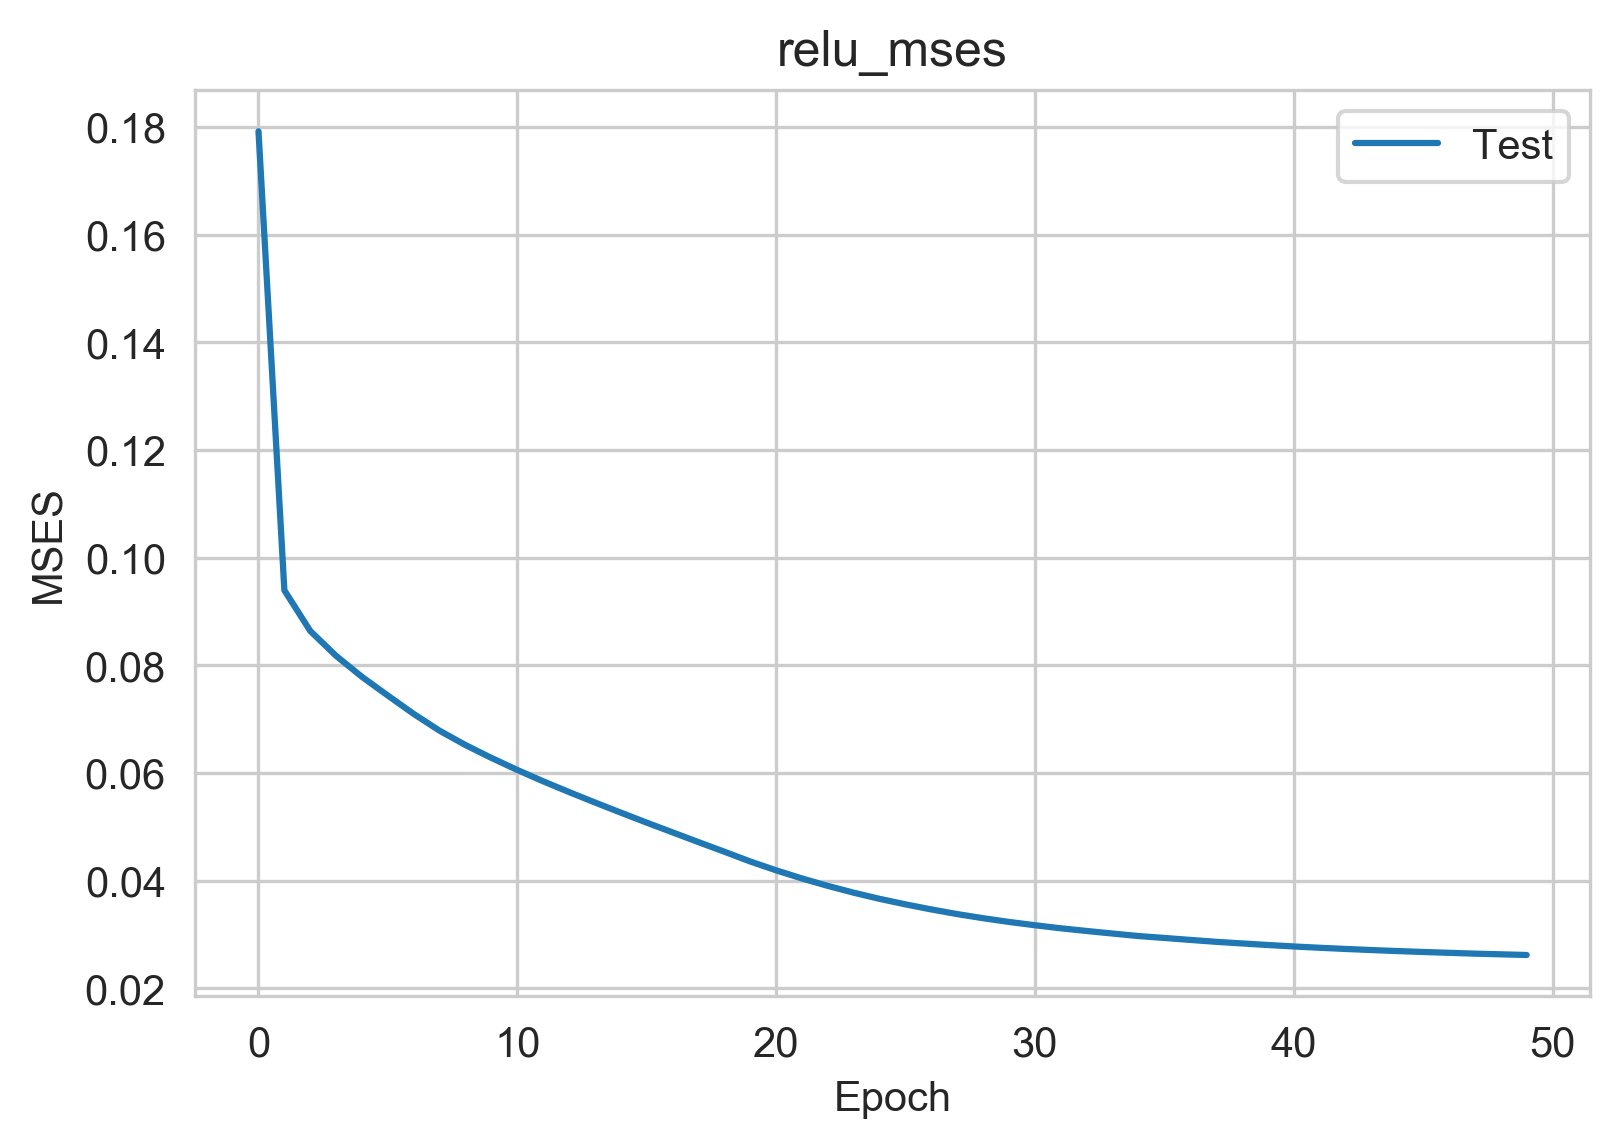

In [94]:
plt.figure()
plt.xlabel('Epoch')
plt.title("relu_mses")
plt.ylabel('MSES')
plt.plot(relu_mses,  label='Test')

plt.legend()

# plt.savefig('auto.svg')
plt.show() 

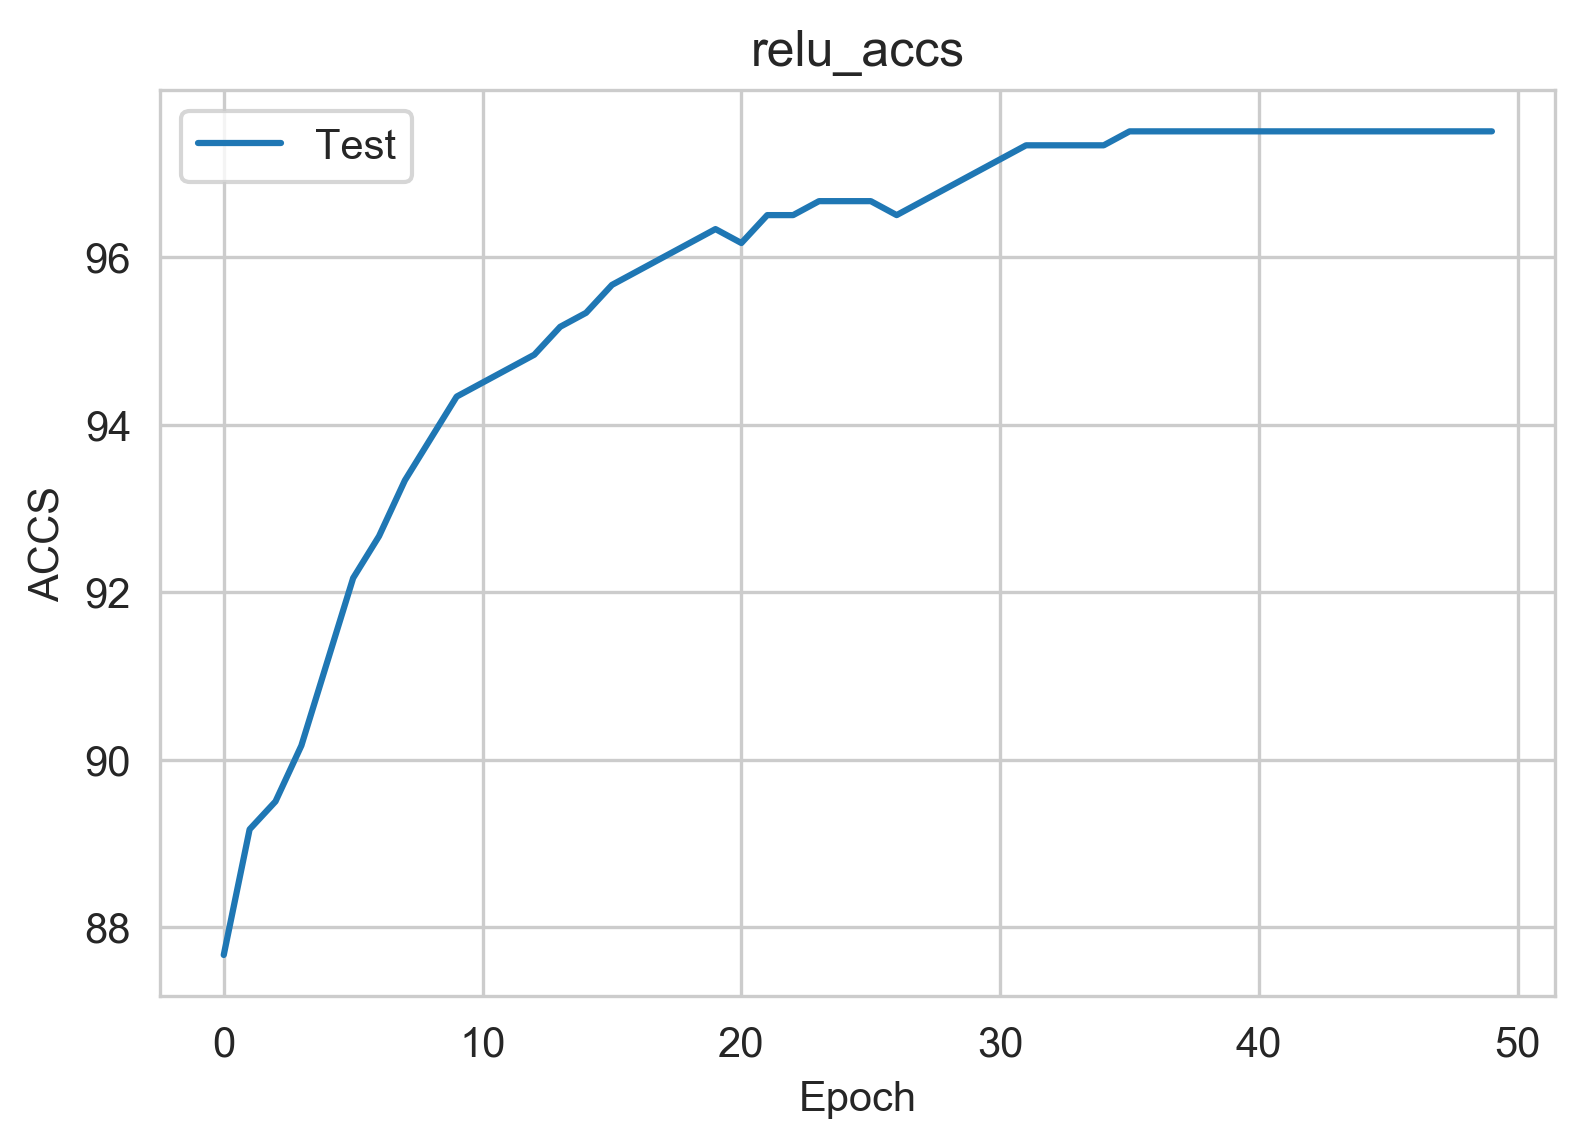

In [95]:
plt.figure()
plt.xlabel('Epoch')
plt.title("relu_accs")
plt.ylabel('ACCS')
plt.plot(relu_accs,  label='Test')

plt.legend()

# plt.savefig('auto.svg')
plt.show() 

In [60]:
nn = NeuralNetwork() # 实例化网络类
nn.add_layer(Layer(2, 25, 'tanh')) # 隐藏层1, 2=>25
nn.add_layer(Layer(25, 50, 'tanh')) # 隐藏层2, 25=>50
nn.add_layer(Layer(50, 25, 'tanh')) # 隐藏层3, 50=>25
nn.add_layer(Layer(25, 2, 'tanh')) # 输出层, 25=>2

tanh_mses,tanh_accs = nn.train(X_train,X_test,y_train,y_test,0.001,500)

Epoch: #0, MSE: 0.112945
Accuracy: 87.00%
Epoch: #10, MSE: 0.103630
Accuracy: 88.33%
Epoch: #20, MSE: 0.097067
Accuracy: 89.33%
Epoch: #30, MSE: 0.090763
Accuracy: 90.17%
Epoch: #40, MSE: 0.084633
Accuracy: 90.83%
Epoch: #50, MSE: 0.077740
Accuracy: 92.33%
Epoch: #60, MSE: 0.070951
Accuracy: 94.00%
Epoch: #70, MSE: 0.065486
Accuracy: 95.00%
Epoch: #80, MSE: 0.061250
Accuracy: 95.67%
Epoch: #90, MSE: 0.056939
Accuracy: 95.83%
Epoch: #100, MSE: 0.052428
Accuracy: 96.00%
Epoch: #110, MSE: 0.049222
Accuracy: 96.17%
Epoch: #120, MSE: 0.047341
Accuracy: 96.33%
Epoch: #130, MSE: 0.046086
Accuracy: 96.50%
Epoch: #140, MSE: 0.045140
Accuracy: 96.50%
Epoch: #150, MSE: 0.044406
Accuracy: 96.83%
Epoch: #160, MSE: 0.043820
Accuracy: 96.83%
Epoch: #170, MSE: 0.043336
Accuracy: 96.83%
Epoch: #180, MSE: 0.042919
Accuracy: 96.83%
Epoch: #190, MSE: 0.042549
Accuracy: 96.83%
Epoch: #200, MSE: 0.042211
Accuracy: 96.83%
Epoch: #210, MSE: 0.041895
Accuracy: 96.83%
Epoch: #220, MSE: 0.041595
Accuracy: 96.83%

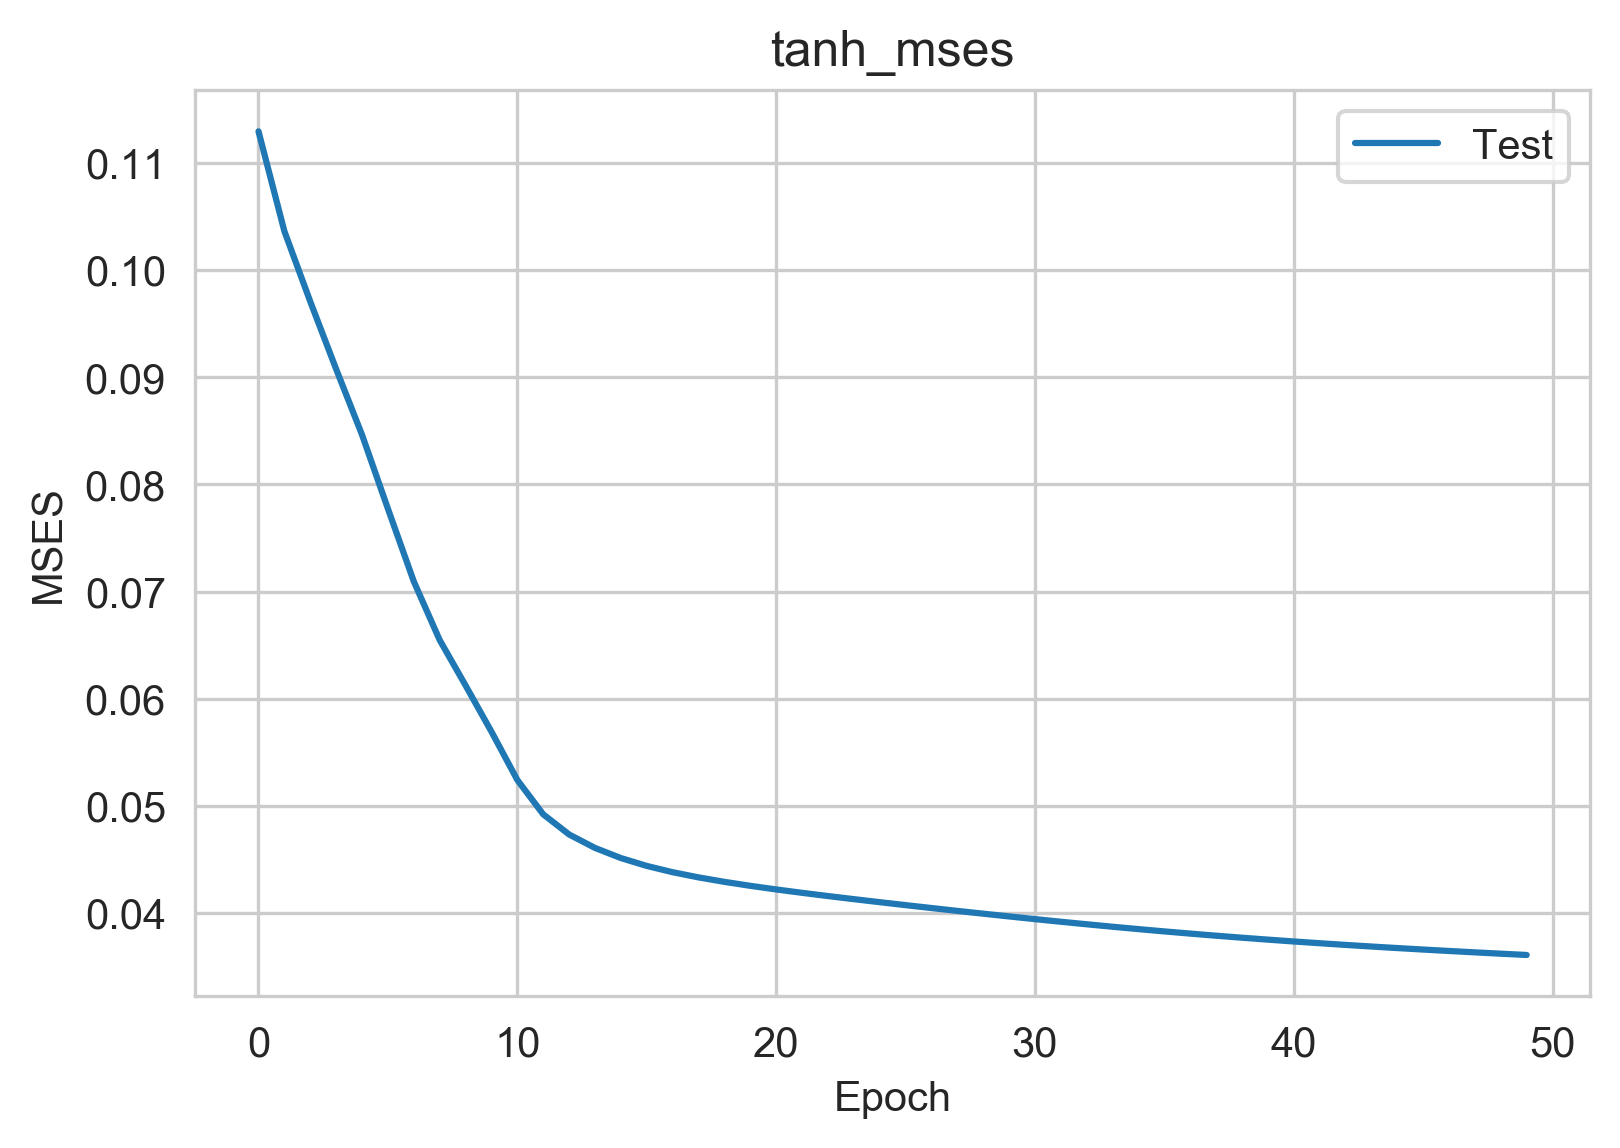

In [96]:
plt.figure()
plt.xlabel('Epoch')
plt.title("tanh_mses")
plt.ylabel('MSES')
plt.plot(tanh_mses,  label='Test')

plt.legend()

# plt.savefig('auto.svg')
plt.show() 

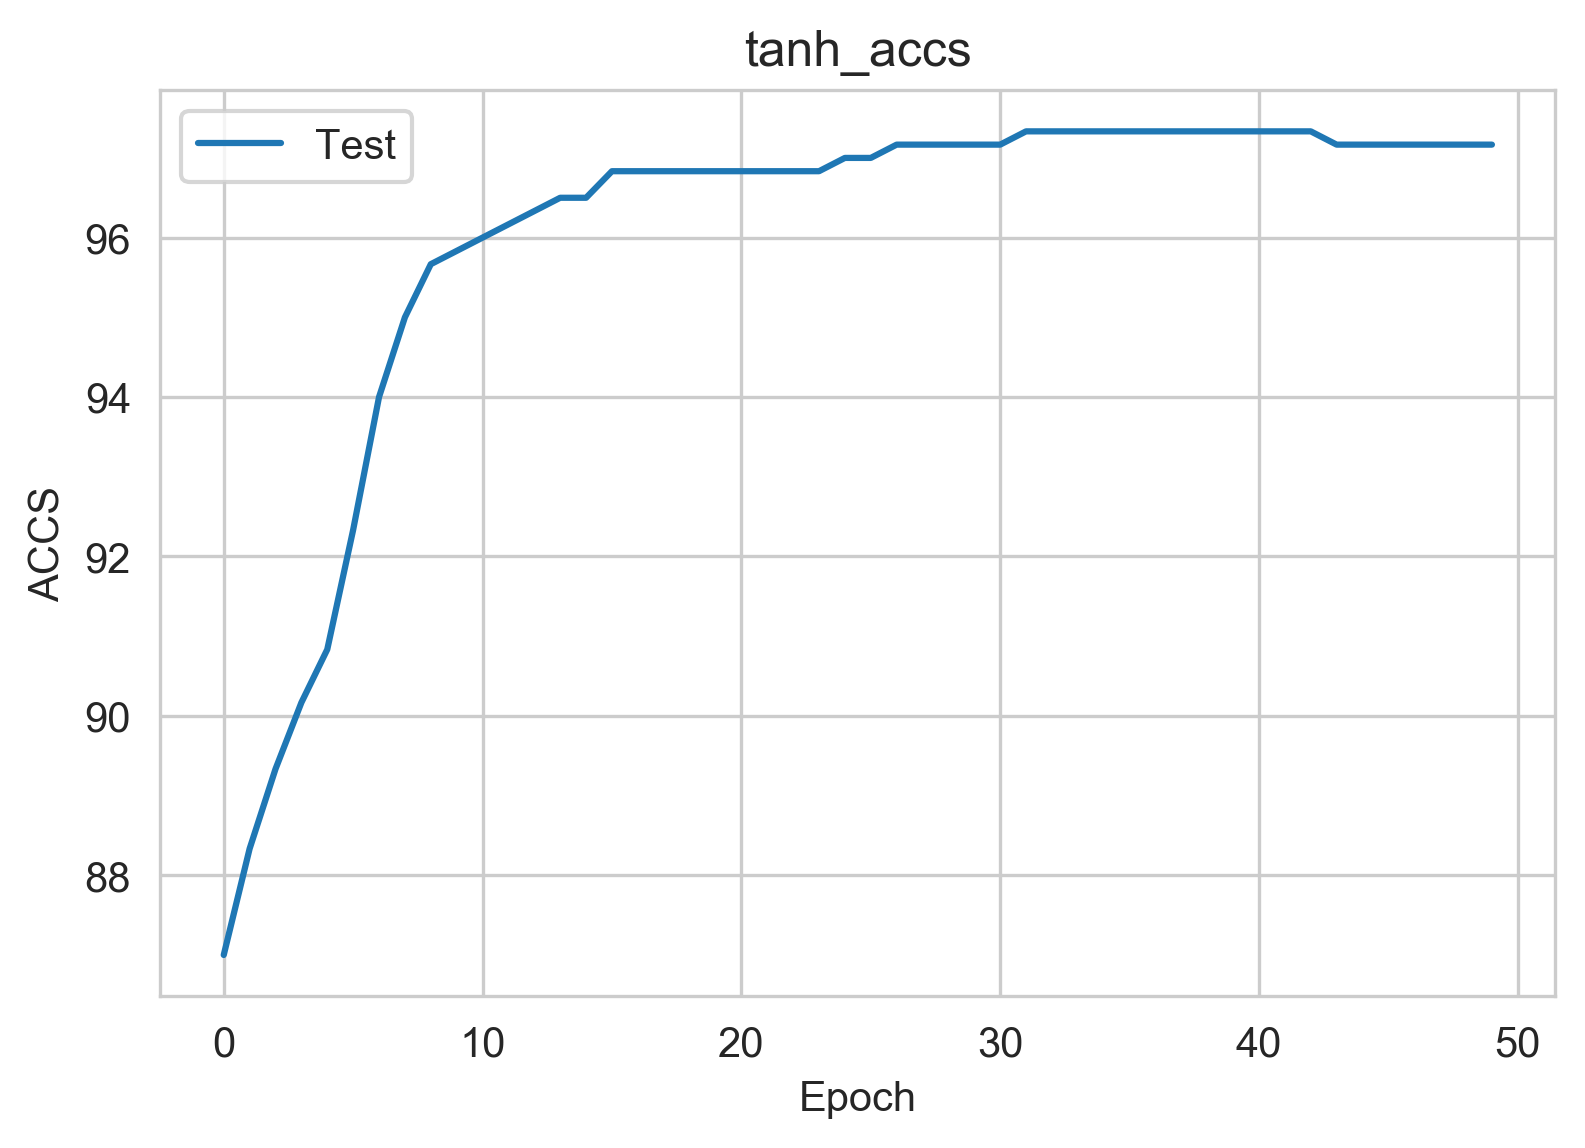

In [97]:
plt.figure()
plt.xlabel('Epoch')
plt.title("tanh_accs")
plt.ylabel('ACCS')
plt.plot(tanh_accs,  label='Test')

plt.legend()

# plt.savefig('auto.svg')
plt.show() 

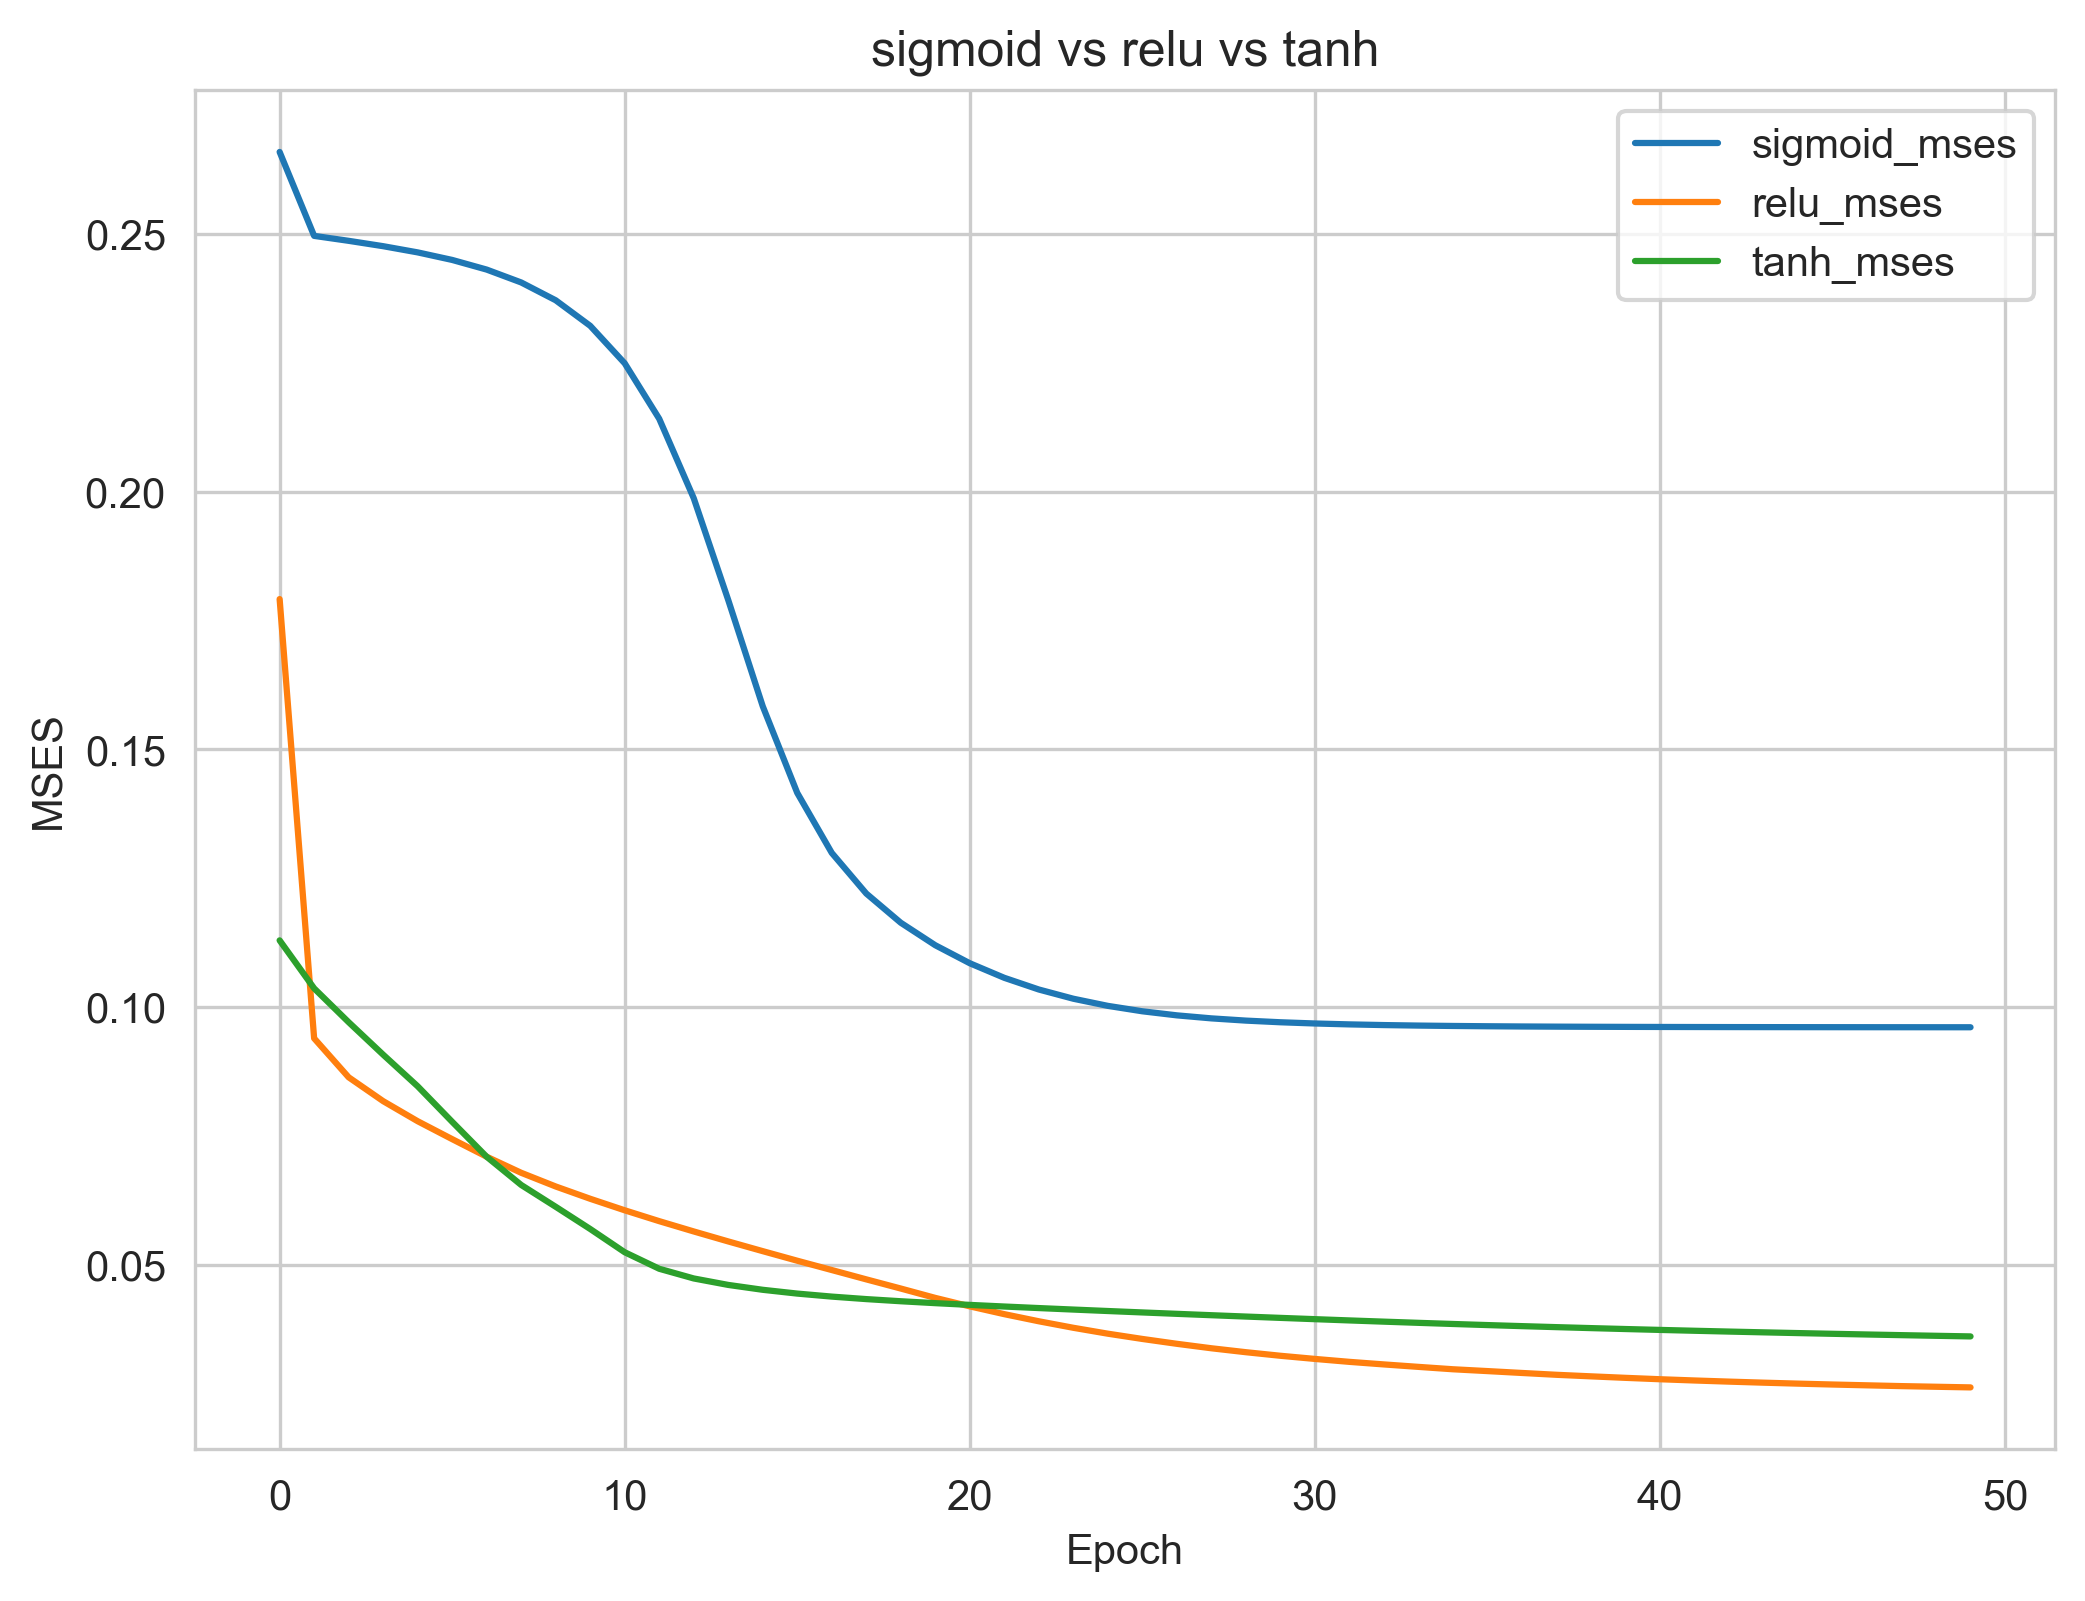

In [98]:
plt.figure(figsize=(8,6))
plt.xlabel('Epoch')
plt.title("sigmoid vs relu vs tanh")
plt.ylabel('MSES')
plt.plot(sigmoid_mses,  label='sigmoid_mses')
plt.plot(relu_mses,  label='relu_mses')
plt.plot(tanh_mses,  label='tanh_mses')

plt.legend()

# plt.savefig('auto.svg')
plt.show() 

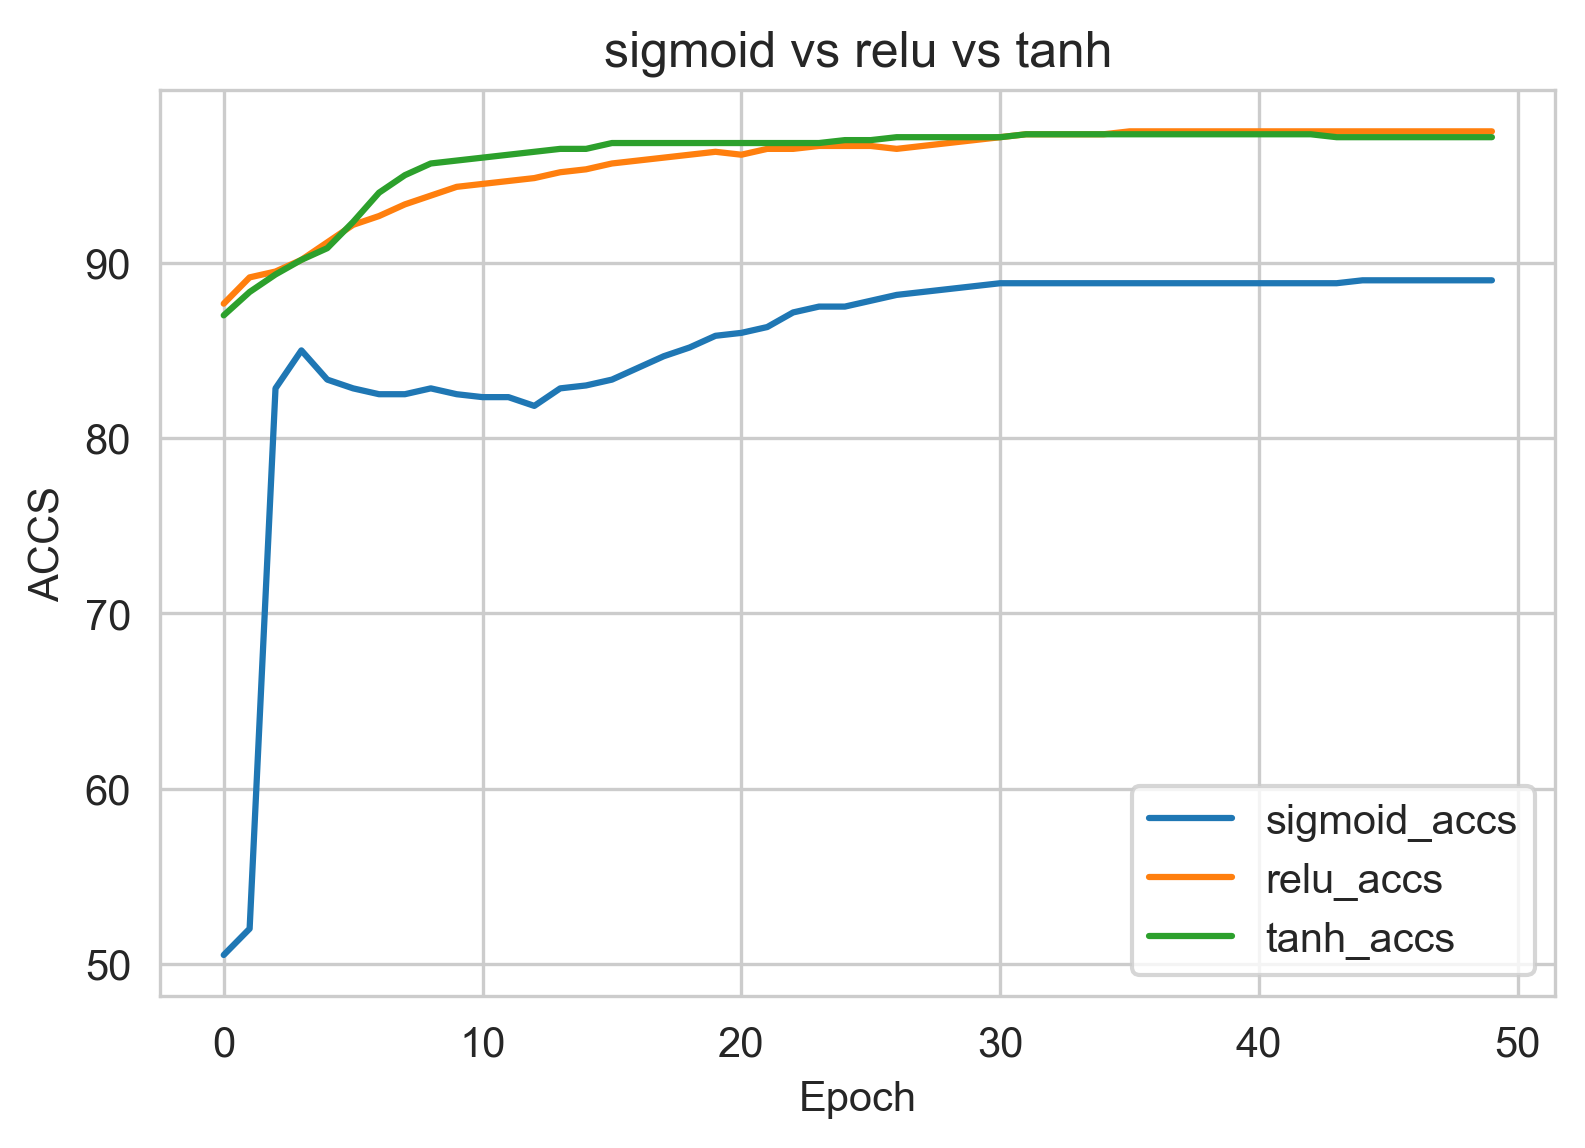

In [99]:
plt.figure()
plt.xlabel('Epoch')
plt.title("sigmoid vs relu vs tanh")
plt.ylabel('ACCS')
plt.plot(sigmoid_accs,  label='sigmoid_accs')
plt.plot(relu_accs,  label='relu_accs')
plt.plot(tanh_accs,  label='tanh_accs')
plt.legend()

# plt.savefig('auto.svg')
plt.show() 

## 彩蛋

In [44]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
N_SAMPLES=2000
TEST_SIZE=0.3
X,y=make_moons(n_samples=N_SAMPLES,noise=0.2,random_state=100)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=TEST_SIZE,random_state=42)
print(X.shape,y.shape)

(2000, 2) (2000,)


In [81]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='sigmoid'),
    tf.keras.layers.Dense(50, activation='sigmoid'),
    tf.keras.layers.Dense(25, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
sigmoid_history=model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,validation_steps=10)

Train on 1400 samples, validate on 600 samples
Epoch 1/50
1400/1400 [==============================] - 1s 491us/sample - loss: 0.6948 - accuracy: 0.5193 - val_loss: 0.3682 - val_accuracy: 0.6938
Epoch 2/50
1400/1400 [==============================] - 0s 97us/sample - loss: 0.6888 - accuracy: 0.6350 - val_loss: 0.3649 - val_accuracy: 0.8344
Epoch 3/50
1400/1400 [==============================] - 0s 92us/sample - loss: 0.6799 - accuracy: 0.7443 - val_loss: 0.3580 - val_accuracy: 0.8188
Epoch 4/50
1400/1400 [==============================] - 0s 99us/sample - loss: 0.6580 - accuracy: 0.8107 - val_loss: 0.3371 - val_accuracy: 0.8313
Epoch 5/50
1400/1400 [==============================] - 0s 107us/sample - loss: 0.5978 - accuracy: 0.8207 - val_loss: 0.2901 - val_accuracy: 0.8094
Epoch 6/50
1400/1400 [==============================] - 0s 112us/sample - loss: 0.4936 - accuracy: 0.8164 - val_loss: 0.2247 - val_accuracy: 0.8375
Epoch 7/50
1400/1400 [==============================] - 0s 110us/sam

In [82]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
relu_history=model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,validation_steps=10)

Train on 1400 samples, validate on 600 samples
Epoch 1/50
1400/1400 [==============================] - 1s 376us/sample - loss: 0.6051 - accuracy: 0.7457 - val_loss: 0.2434 - val_accuracy: 0.8281
Epoch 2/50
1400/1400 [==============================] - 0s 103us/sample - loss: 0.3571 - accuracy: 0.8464 - val_loss: 0.1439 - val_accuracy: 0.8719
Epoch 3/50
1400/1400 [==============================] - 0s 99us/sample - loss: 0.2861 - accuracy: 0.8636 - val_loss: 0.1310 - val_accuracy: 0.8938
Epoch 4/50
1400/1400 [==============================] - 0s 104us/sample - loss: 0.2657 - accuracy: 0.8729 - val_loss: 0.1191 - val_accuracy: 0.9031
Epoch 5/50
1400/1400 [==============================] - 0s 104us/sample - loss: 0.2456 - accuracy: 0.8864 - val_loss: 0.1029 - val_accuracy: 0.9281
Epoch 6/50
1400/1400 [==============================] - 0s 123us/sample - loss: 0.2172 - accuracy: 0.9093 - val_loss: 0.0901 - val_accuracy: 0.9375
Epoch 7/50
1400/1400 [==============================] - 0s 127us/s

In [83]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(2, activation='tanh'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tanh_history=model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,validation_steps=10)

Train on 1400 samples, validate on 600 samples
Epoch 1/50
1400/1400 [==============================] - 1s 375us/sample - loss: 0.8249 - accuracy: 0.5950 - val_loss: 0.2874 - val_accuracy: 0.6469
Epoch 2/50
1400/1400 [==============================] - 0s 97us/sample - loss: 0.5472 - accuracy: 0.6629 - val_loss: 0.3009 - val_accuracy: 0.6750
Epoch 3/50
1400/1400 [==============================] - 0s 99us/sample - loss: 0.5695 - accuracy: 0.6829 - val_loss: 0.3384 - val_accuracy: 0.7063
Epoch 4/50
1400/1400 [==============================] - 0s 100us/sample - loss: 0.6148 - accuracy: 0.7093 - val_loss: 0.3042 - val_accuracy: 0.7375
Epoch 5/50
1400/1400 [==============================] - 0s 101us/sample - loss: 0.6237 - accuracy: 0.6671 - val_loss: 0.3451 - val_accuracy: 0.6906
Epoch 6/50
1400/1400 [==============================] - 0s 104us/sample - loss: 0.6574 - accuracy: 0.8107 - val_loss: 0.3514 - val_accuracy: 0.8469
Epoch 7/50
1400/1400 [==============================] - 0s 99us/sam

In [84]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(2, activation='tanh'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
relu_tanh_history=model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,validation_steps=10)

Train on 1400 samples, validate on 600 samples
Epoch 1/50
1400/1400 [==============================] - 1s 363us/sample - loss: 0.6728 - accuracy: 0.7257 - val_loss: 0.3212 - val_accuracy: 0.7531
Epoch 2/50
1400/1400 [==============================] - 0s 97us/sample - loss: 0.6115 - accuracy: 0.7436 - val_loss: 0.3339 - val_accuracy: 0.7594
Epoch 3/50
1400/1400 [==============================] - 0s 101us/sample - loss: 0.6154 - accuracy: 0.7471 - val_loss: 0.3339 - val_accuracy: 0.7594
Epoch 4/50
1400/1400 [==============================] - 0s 94us/sample - loss: 0.6149 - accuracy: 0.7471 - val_loss: 0.3339 - val_accuracy: 0.7594
Epoch 5/50
1400/1400 [==============================] - 0s 96us/sample - loss: 0.6115 - accuracy: 0.7471 - val_loss: 0.3281 - val_accuracy: 0.7563
Epoch 6/50
1400/1400 [==============================] - 0s 99us/sample - loss: 0.6618 - accuracy: 0.7721 - val_loss: 0.3697 - val_accuracy: 0.8156
Epoch 7/50
1400/1400 [==============================] - 0s 102us/samp

In [ ]:
relu_history
relu_tanh_history
tanh_history

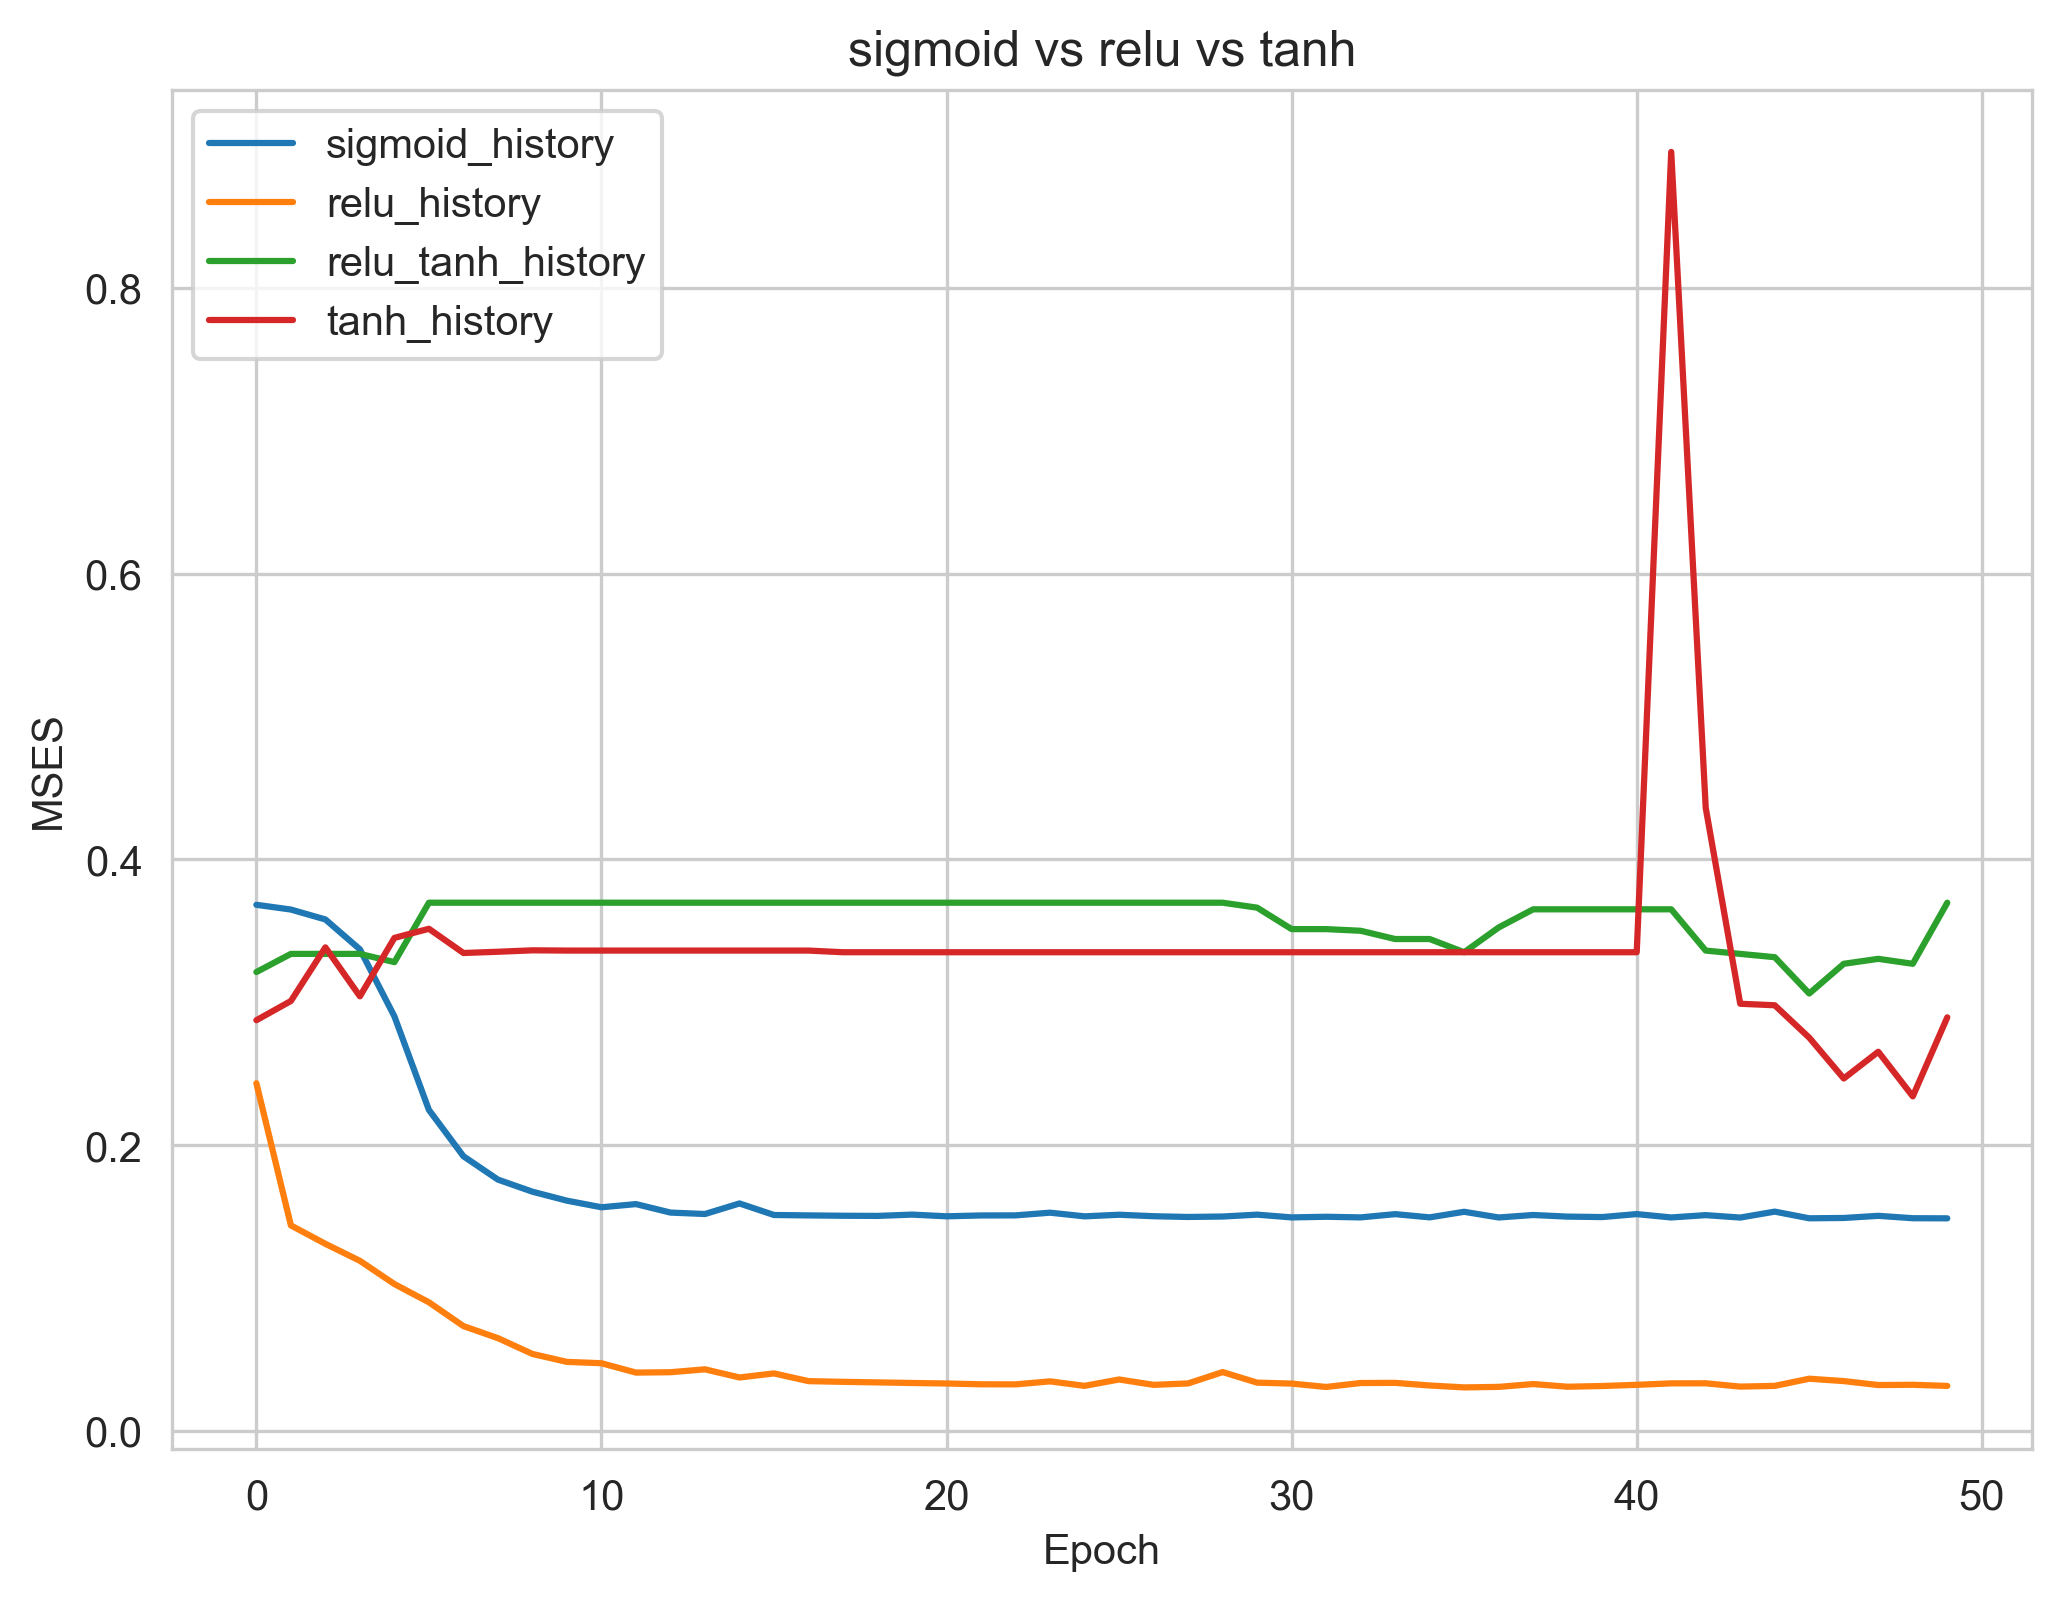

In [89]:
plt.figure(figsize=(8,6))
plt.xlabel('Epoch')
plt.title("sigmoid vs relu vs tanh")
plt.ylabel('MSES')
plt.plot(sigmoid_history.history['val_loss'],  label='sigmoid_history')
plt.plot(relu_history.history['val_loss'],  label='relu_history')
plt.plot(relu_tanh_history.history['val_loss'],  label='relu_tanh_history')
plt.plot(tanh_history.history['val_loss'],  label='tanh_history')
plt.legend()

# plt.savefig('auto.svg')
plt.show() 

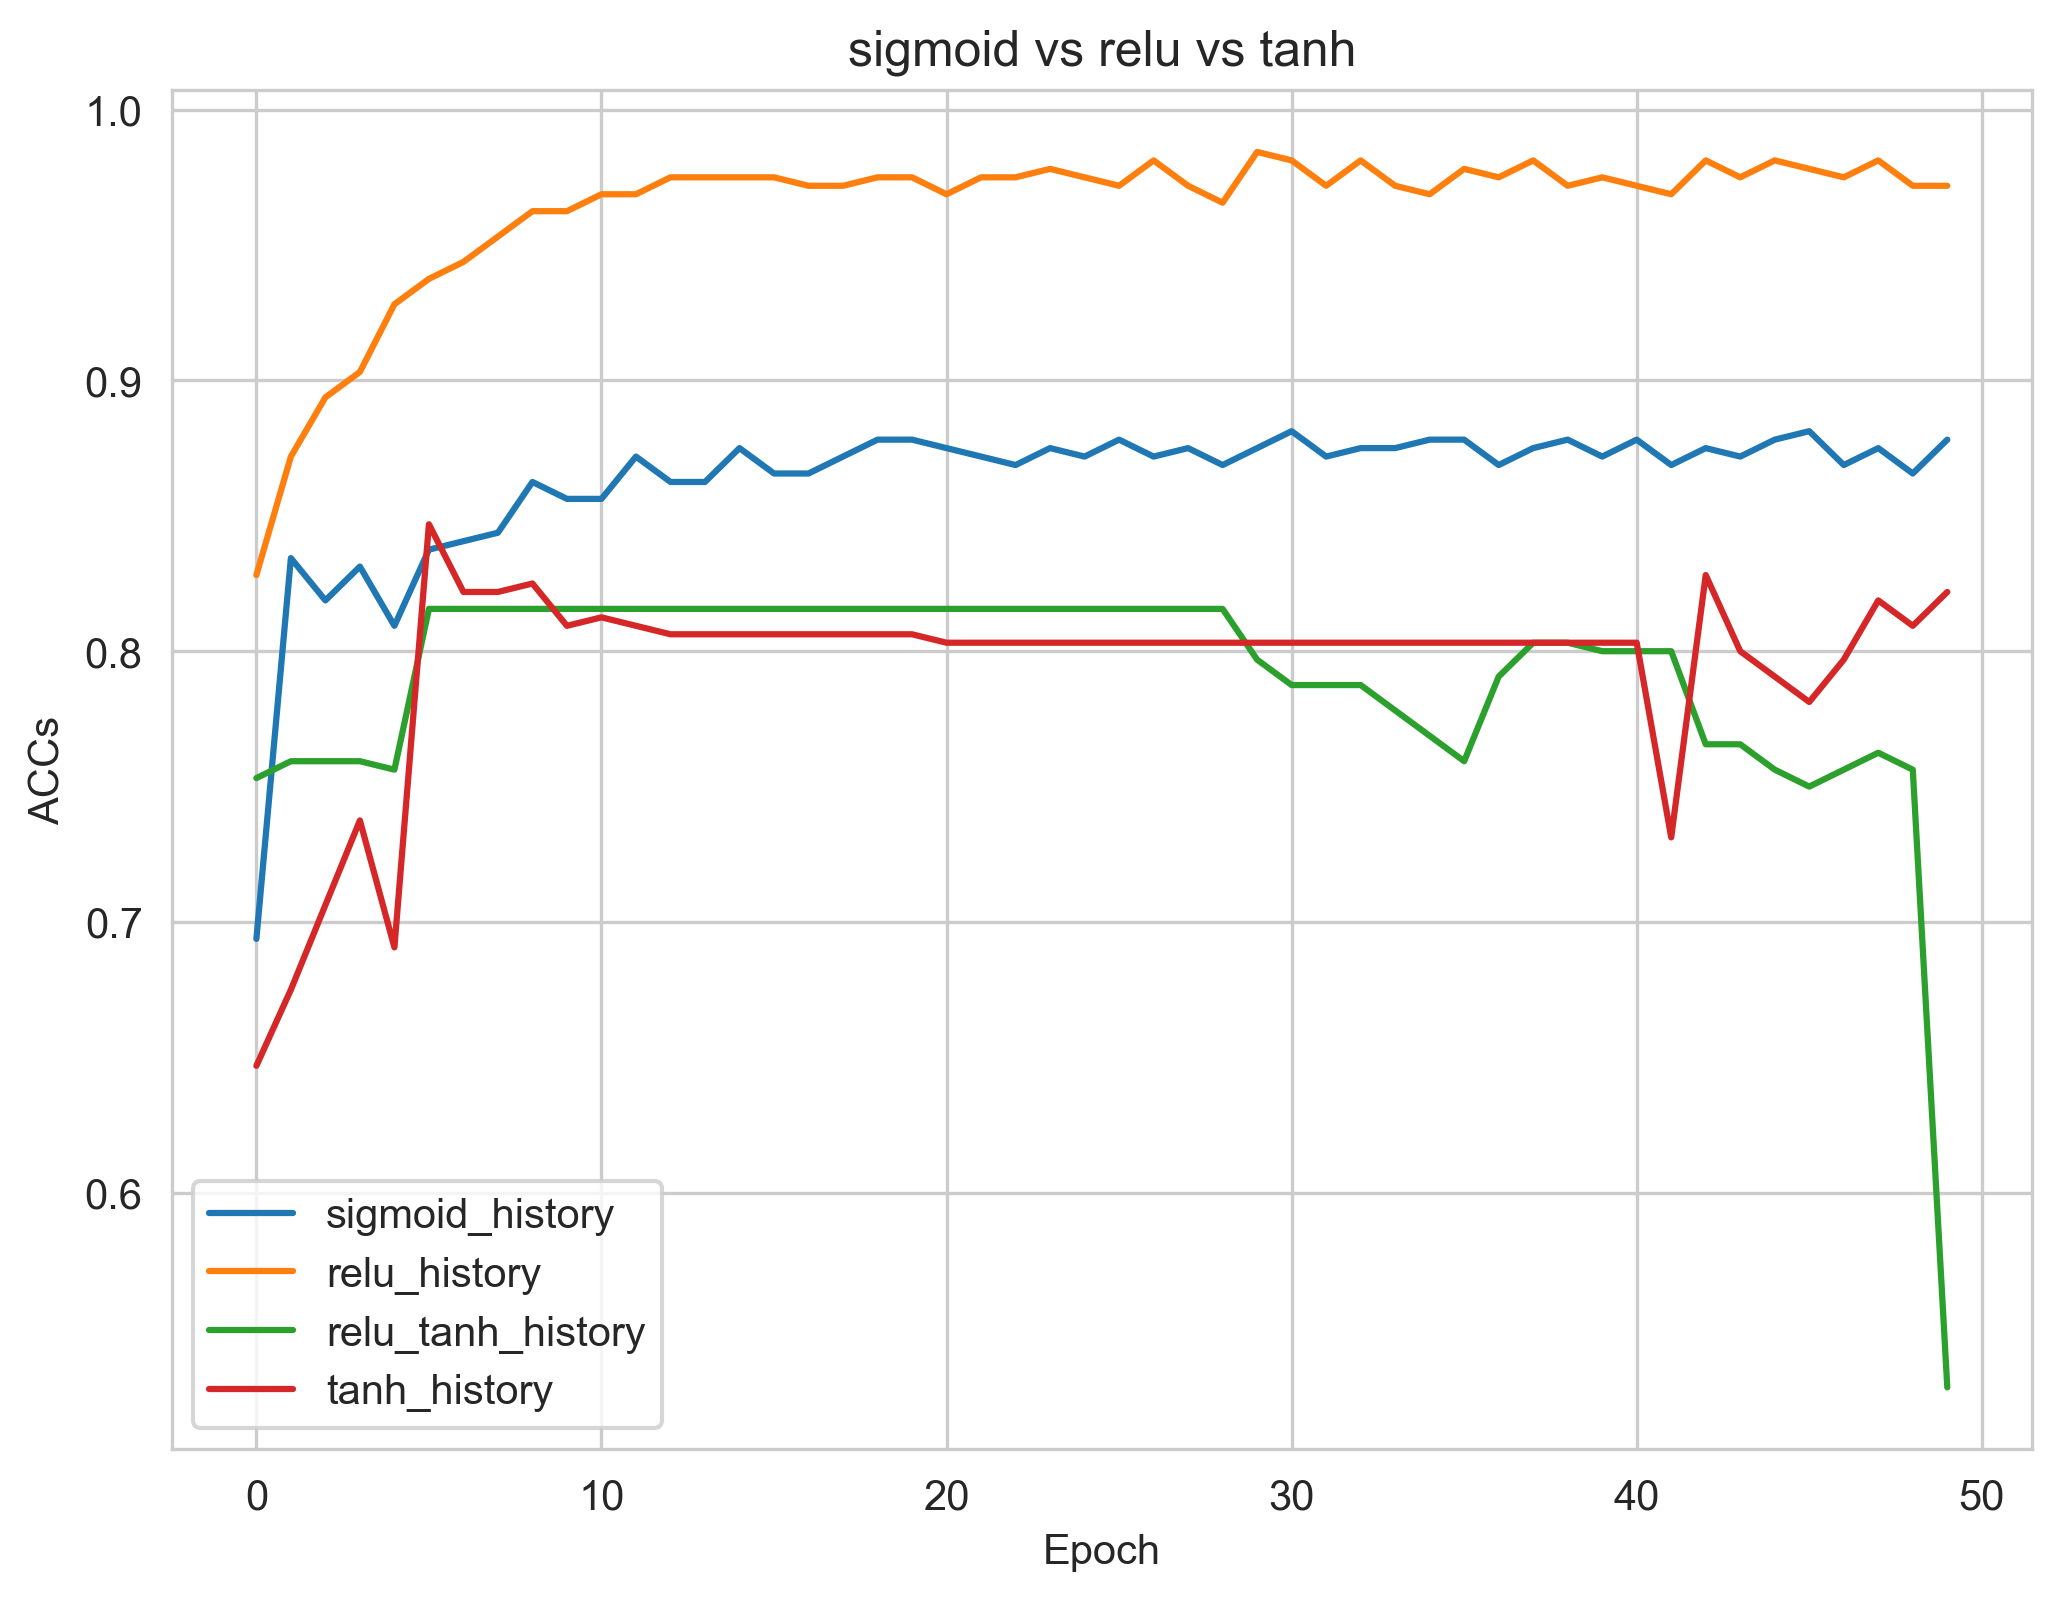

In [90]:
plt.figure(figsize=(8,6))
plt.xlabel('Epoch')
plt.title("sigmoid vs relu vs tanh")
plt.ylabel('ACCs')
plt.plot(sigmoid_history.history['val_accuracy'],  label='sigmoid_history')
plt.plot(relu_history.history['val_accuracy'],  label='relu_history')
plt.plot(relu_tanh_history.history['val_accuracy'],  label='relu_tanh_history')
plt.plot(tanh_history.history['val_accuracy'],  label='tanh_history')
plt.legend()

# plt.savefig('auto.svg')
plt.show() 